# PINK Demo: Training of a SOM with Shape Images

## Install PINK

As long as PINK 2.5 is not available at PyPI, the package will be installed directly from the repository.

In [1]:
!pip install git+https://github.com/BerndDoser/PINK.git@pypi

import pink
print(pink.__version__)

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/BerndDoser/PINK.git (to revision pypi) to /tmp/pip-req-build-uif9id5p
  Running command git clone --filter=blob:none --quiet https://github.com/BerndDoser/PINK.git /tmp/pip-req-build-uif9id5p
  Running command git checkout -b pypi --track origin/pypi
  Switched to a new branch 'pypi'
  Branch 'pypi' set up to track remote branch 'pypi' from 'origin'.
  Resolved https://github.com/BerndDoser/PINK.git to commit b2f2968d8e1f416499c933f858f46c364ea61321
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


## Download training data

The HDF5 file with shape images for demonstration will be downloaded from Google Drive.

In [8]:
!pip install --upgrade gdown

import gdown

url = 'https://drive.google.com/uc?id=15XaP03kRvSvtEyXLMlQHMxtsLtf93Rjr'
gdown.download(url, 'shapes.h5')

Downloading...
From: https://drive.google.com/uc?id=15XaP03kRvSvtEyXLMlQHMxtsLtf93Rjr
To: /content/shapes.h5
100%|██████████| 65.5M/65.5M [00:00<00:00, 112MB/s]


'shapes.h5'

## Read and shuffle the training dataset

In [10]:
import h5py
import numpy as np

dataset = []
with h5py.File('/content/shapes.h5','r') as f:
    dataset.append(f["boxes"][:])
    dataset.append(f["circles"][:])
    dataset.append(f["crosses"][:])
    dataset.append(f["triangles"][:])
images = np.concatenate(dataset)

np.random.seed(1234)
np.random.shuffle(images)

print('shape:     ', images.shape)
print('min value: ', np.amin(images))
print('max value: ', np.amax(images))

shape:      (4000, 64, 64)
min value:  4.752752e-09
max value:  1.0


## Show the first 25 images of the dataset

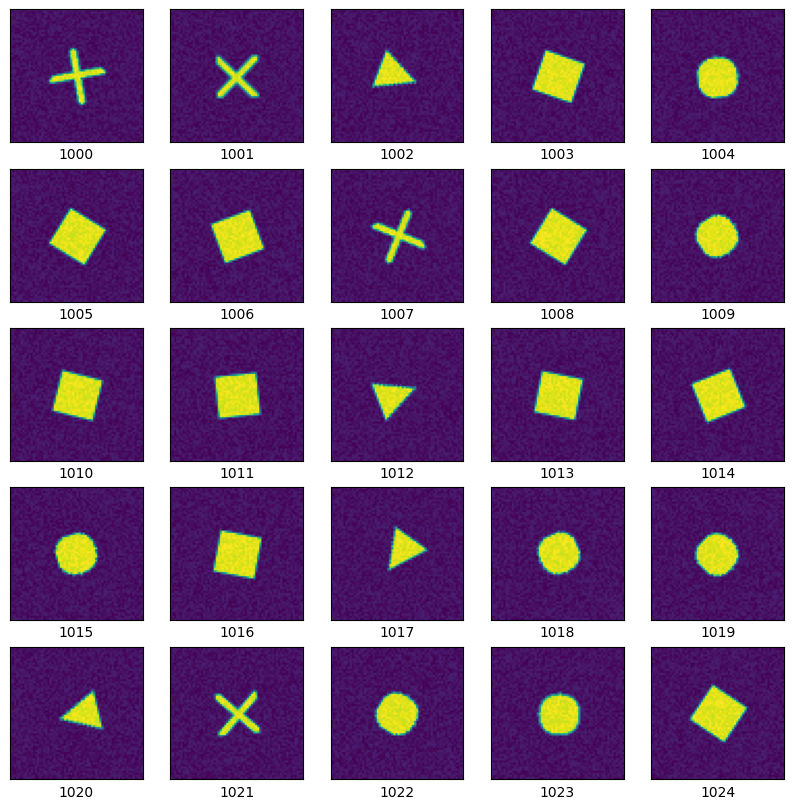

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(i)

## Setup the Trainer and the Dataloader

In [12]:
import math

som_dim = 8
neuron_dim = int(images.shape[1] / math.sqrt(2.0) * 2.0)
euclid_dim = int(images.shape[1] * math.sqrt(2.0) / 2.0)
print("neuron_dim = ", neuron_dim)
print("euclid_dim = ", euclid_dim)

np_som = np.random.rand(som_dim, som_dim, neuron_dim, neuron_dim).astype(np.float32)
som = pink.SOM(np_som)

data = [pink.Data(images[i]) for i in range(len(images))]

trainer = pink.Trainer(som, euclidean_distance_dim=euclid_dim)

neuron_dim =  90
euclid_dim =  45


## Execute the training over 1 epoch

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

train:   0%|          | 0/4000 [00:00<?, ?it/s]

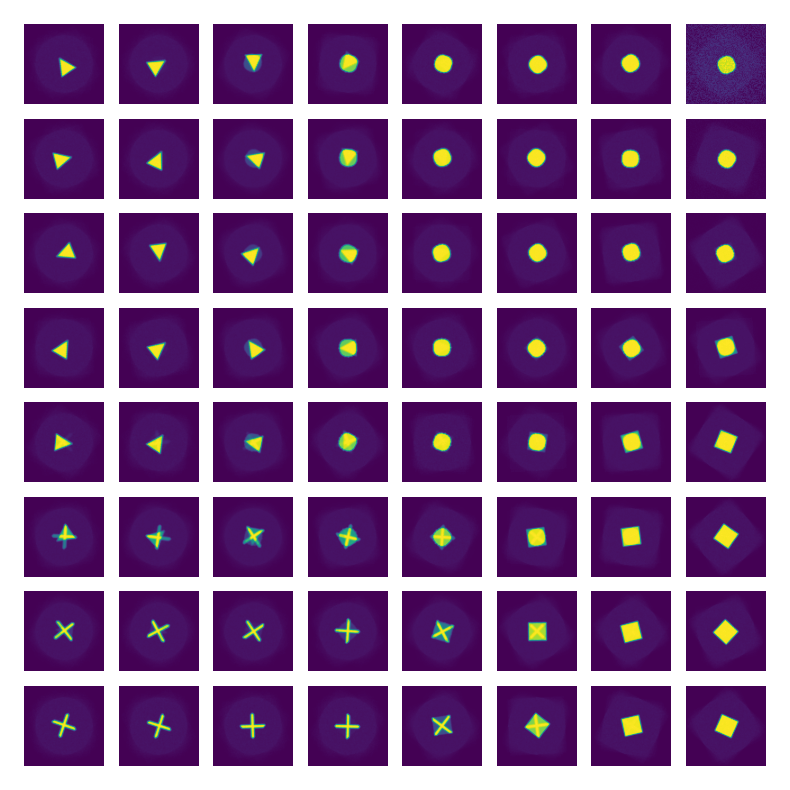

In [13]:
from pink import tools
import ipywidgets as widgets
from tqdm.notebook import tqdm

widgets.Checkbox(
    value=False,
    description='Interrupt',
    disabled=False
)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig.show()

for iter in tqdm(range(1), desc="epoch"):
    for i in tqdm(range(len(images)), desc="train", leave=False):

        trainer(data[i])

        if not i % 100:
            trainer.update_som()

            image = tools.show(som, border=15)

            ax.clear()
            ax.axis("off")
            ax.imshow(image)
            fig.canvas.draw()

## Store the SOM as numpy file

In [14]:
np.save("som-shapes-cartesian2d-8x8.npy", np.array(som, copy=True))